# CSE473s Project

## Part 1 (XOR)
Implement our custom library, test it with [XOR] problem, validate it, and also implement the same exact problem using [TesnorFlow] or [Keras] then compare the results.

### Data initialization

In [52]:
import numpy as np
np.random.seed(42)

X = np.array([[-1, -1],[-1, 1],[1, -1],[1, 1]], dtype=np.float32)
y_true = np.array([[-1],[1],[1],[-1]], dtype=np.float32)

### Build netwrok with our custom library

In [53]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))
from lib import Sequential, Dense, Tanh, Sigmoid, ReLU, Softmax, MSELoss, SGDOptimizer as SGD

model = Sequential([
    Dense(2, 4, 0.1), Tanh(), Dense(4, 1, 0.1), Tanh()
])

opt = SGD(learning_rate=1.0)
loss_fn = MSELoss()

### Training loop

In [ ]:
W1_init = model.layers[0].params[0].copy()
b1_init = model.layers[0].params[1].copy()
W2_init = model.layers[2].params[0].copy()
b2_init = model.layers[2].params[1].copy()

n_epochs = 10000

model.fit(X, y_true, loss_fn, opt, epochs=n_epochs)

[[-0.04694744  0.054256   -0.04634177 -0.04657298]]
Epoch 0, Loss: 0.5055565845045331
Epoch 100, Loss: 0.005238414682047792
Epoch 200, Loss: 0.0014561652331024385
Epoch 300, Loss: 0.0008220678957265323
Epoch 400, Loss: 0.0005675714746434494
Epoch 500, Loss: 0.0004315507010069525
Epoch 600, Loss: 0.0003472713340780507
Epoch 700, Loss: 0.0002900788978519814
Epoch 800, Loss: 0.0002487940995165468
Epoch 900, Loss: 0.00021762794325557323
Epoch 1000, Loss: 0.00019328805637913341
Epoch 1100, Loss: 0.00017376624002336197
Epoch 1200, Loss: 0.00015776917882511567
Epoch 1300, Loss: 0.00014442694970752715
Epoch 1400, Loss: 0.0001331332152452594
Epoch 1500, Loss: 0.00012345262116732008
Epoch 1600, Loss: 0.00011506461729137583
Epoch 1700, Loss: 0.000107728032309456
Epoch 1800, Loss: 0.00010125798531101837
Epoch 1900, Loss: 9.551040175621197e-05
Epoch 2000, Loss: 9.037136686373131e-05
Epoch 2100, Loss: 8.574964231874157e-05
Epoch 2200, Loss: 8.157130262727999e-05
Epoch 2300, Loss: 7.777582295582875e-

### Assert correctness

In [55]:
y_pred = model.forward(X)

print("Raw preds:\n", y_pred)
print("Rounded:\n", np.int8(np.round(y_pred)))

y_test = model.forward([-2.0, 3.0])
print("\nTest with random input (e.g.; [-2.0, 3.0]):", np.int8(np.round(y_test)))

Raw preds:
 [[-0.99361529]
 [ 0.99462898]
 [ 0.99493332]
 [-0.99385247]]
Rounded:
 [[-1]
 [ 1]
 [ 1]
 [-1]]

Test with random input (e.g.; [-2.0, 3.0]): [[0]]


### Plotting
Plotting the classifier boundary layers

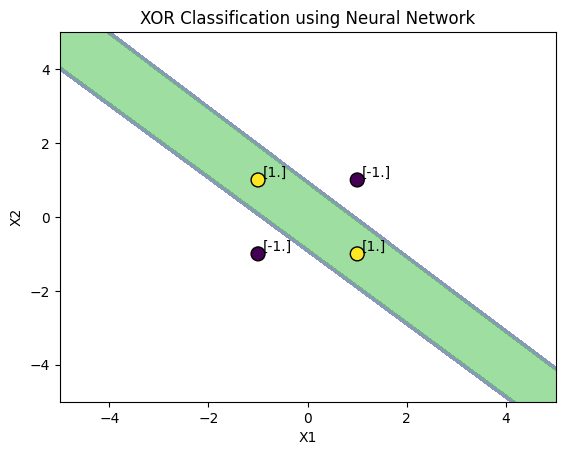

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Create a grid of points for visualization
xx, yy = np.meshgrid(
    np.linspace(-5.0, 5.0, 200),
    np.linspace(-5.0, 5.0, 200)
)

grid_points = np.c_[xx.ravel(), yy.ravel()]  # shape (40000, 2)

# Predict on the grid
Z = model.forward(grid_points)  # shape (40000, 1)
Z = Z.reshape(xx.shape)         # reshape to (200, 200)

# Plot classification regions
plt.contourf(xx, yy, Z, levels=[0,0.5,1], alpha=0.6)

# Plot XOR data points
plt.scatter(X[:, 0], X[:, 1], s=100, c=y_true, edgecolors='k')
for i, txt in enumerate(y_true):
    plt.text(X[i, 0] + 0.1, X[i, 1] + 0.1, str(txt))

plt.title("XOR Classification using Neural Network")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

### Section (1) [Gradient-Checking]
Proving that our backpropagation is correct, by comparing its gradients with the gradients of numerical gradient descent.

#### Numerical gradient descent function

In [57]:
import numpy as np

def numerical_gradient(model, X, y_true, loss_fn, epsilon=1e-5):
    numerical_grads = []

    for layer in model.layers:
        layer_grads = []

        if layer.trainable:
            for param in layer.params:
                grad = np.zeros_like(param)

                it = np.nditer(param, flags=['multi_index'], op_flags=['readwrite'])
                while not it.finished:
                    idx = it.multi_index
                    original_value = param[idx]

                    param[idx] = original_value + epsilon
                    loss_plus = loss_fn(y_true, model.forward(X))

                    param[idx] = original_value - epsilon
                    loss_minus = loss_fn(y_true, model.forward(X))

                    grad[idx] = (loss_plus - loss_minus) / (2 * epsilon)

                    param[idx] = original_value
                    it.iternext()
                
                layer_grads.append(grad)
        
        numerical_grads.append(layer_grads)

    return numerical_grads

#### Testing & comparing between our backprop and numerical gradient

In [58]:

# Compute numerical gradients
numerical_grads = numerical_gradient(model, X, y_true, loss_fn)
print("\nNumerical Gradients:")
for layer_idx, layer in enumerate(model.layers):
    if layer.trainable:
        print(f"Layer {layer_idx} ({type(layer).__name__}):")
        for param_idx, param in enumerate(layer.params):
            print(f" Param {param_idx} gradient:\n{numerical_grads[layer_idx][param_idx]}")

# Compare with backprop gradients
model.forward(X)
model.backward(loss_fn.backward())
print("\nBackprop Gradients:")
for layer_idx, layer in enumerate(model.layers):
    if layer.trainable:
        print(f"Layer {layer_idx} ({type(layer).__name__}):")
        for param_idx, grad in enumerate(layer.grads):
            print(f" Param {param_idx} gradient:\n{grad}")

# Check if numerical and backprop gradients are close
tolerance = 1e-4
for layer_idx, layer in enumerate(model.layers):
    if layer.trainable:
        for param_idx in range(len(layer.params)):
            num_grad = numerical_grads[layer_idx][param_idx]
            backprop_grad = layer.grads[param_idx]
            print(f"\nDifference for Layer {layer_idx} Param {param_idx}:\n", num_grad - backprop_grad)
            if not np.allclose(num_grad, backprop_grad, atol=tolerance):
                print(f"Gradient check failed for Layer {layer_idx} Param {param_idx}")
            else:
                print(f"Gradient check passed for Layer {layer_idx} Param {param_idx}")


Numerical Gradients:
Layer 0 (Dense):
 Param 0 gradient:
[[ 6.55987662e-07  6.85333359e-06 -5.37607006e-06  1.91498012e-06]
 [ 1.33914194e-06  6.80285324e-06 -5.37164156e-06  6.54191415e-07]]
 Param 1 gradient:
[[5.76897988e-06 7.49428795e-06 5.70603923e-06 6.26862638e-06]]
Layer 2 (Dense):
 Param 0 gradient:
[[-6.39328730e-06]
 [ 2.52392732e-05]
 [ 2.31352193e-05]
 [-6.75141538e-06]]
 Param 1 gradient:
[[1.19668779e-05]]

Backprop Gradients:
Layer 0 (Dense):
 Param 0 gradient:
[[ 6.55960915e-07  6.85319799e-06 -5.37596295e-06  1.91496703e-06]
 [ 1.33912887e-06  6.80271658e-06 -5.37153439e-06  6.54153235e-07]]
 Param 1 gradient:
[[5.76834439e-06 7.49471086e-06 5.70636792e-06 6.26792731e-06]]
Layer 2 (Dense):
 Param 0 gradient:
[[-6.39257570e-06]
 [ 2.52397613e-05]
 [ 2.31357731e-05]
 [-6.75066483e-06]]
 Param 1 gradient:
[[1.19655549e-05]]

Difference for Layer 0 Param 0:
 [[ 2.67471279e-11  1.35604056e-10 -1.07119553e-10  1.30818680e-11]
 [ 1.30740961e-11  1.36654644e-10 -1.07165781e

### Section (3) [Autoencoder]

In [59]:
import numpy as np
import sys, os
sys.path.insert(0, os.path.abspath('..')) 

from lib import Sequential, Dense, ReLU, Sigmoid, MSELoss, SGDOptimizer as SGD
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

mnist = fetch_openml('mnist_784', version=1, as_frame=False) 
X_mnist = mnist.data.astype(np.float32) / 255.0
y_mnist = mnist.target.astype(np.int64)

X_train, X_test, y_train, y_test = train_test_split(X_mnist, y_mnist, test_size=0.2, random_state=42)

In [76]:
# 3. Define Autoencoder
autoencoder = Sequential([
    Dense(784, 128, 0.1), ReLU(),
    Dense(128, 64, 0.1), ReLU(),
    Dense(64, 32, 0.1), ReLU(),
    Dense(32, 64, 0.1), ReLU(),
    Dense(64, 128, 0.1), ReLU(),
    Dense(128, 784, 0.1), Sigmoid()
])

dense_idx = [0, 2, 4, 6, 8, 10]

ae_init_params = []
for i in dense_idx:
    W = autoencoder.layers[i].params[0].copy()
    b = autoencoder.layers[i].params[1].copy()
    ae_init_params.append((W, b))

print("Saved", len(ae_init_params), "Dense layers init params.")

Saved 6 Dense layers init params.


In [61]:
from tqdm import tqdm

optimizer = SGD(learning_rate=0.005)
loss_fn = MSELoss()

epochs = 10
batch_size = 64

print("Starting training...")

for epoch in range(epochs):
    
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train_shuffled = X_train[indices]
    
    epoch_loss = 0
    num_batches = 0

    for i in tqdm(range(0, X_train.shape[0], batch_size), 
                  desc=f"Epoch {epoch+1}/{epochs}", 
                  unit="batch"):
        
        X_batch = X_train_shuffled[i:i + batch_size]
        
        batch_loss = autoencoder.train_step(X_batch, X_batch, loss_fn, optimizer)
        
        epoch_loss += batch_loss
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    print(f"Loss: {avg_loss:.4f}")

Starting training...


Epoch 1/10: 100%|██████████| 875/875 [00:07<00:00, 124.17batch/s]


Loss: 0.0378


Epoch 2/10: 100%|██████████| 875/875 [00:06<00:00, 128.70batch/s]


Loss: 0.0245


Epoch 3/10: 100%|██████████| 875/875 [00:09<00:00, 93.49batch/s] 


Loss: 0.0193


Epoch 4/10: 100%|██████████| 875/875 [00:05<00:00, 153.82batch/s]


Loss: 0.0168


Epoch 5/10: 100%|██████████| 875/875 [00:05<00:00, 174.29batch/s]


Loss: 0.0152


Epoch 6/10: 100%|██████████| 875/875 [00:10<00:00, 84.54batch/s] 


Loss: 0.0142


Epoch 7/10: 100%|██████████| 875/875 [00:06<00:00, 137.31batch/s]


Loss: 0.0134


Epoch 8/10: 100%|██████████| 875/875 [00:04<00:00, 197.27batch/s]


Loss: 0.0128


Epoch 9/10: 100%|██████████| 875/875 [00:04<00:00, 176.13batch/s]


Loss: 0.0123


Epoch 10/10: 100%|██████████| 875/875 [00:04<00:00, 191.67batch/s]

Loss: 0.0117


reconstructing...


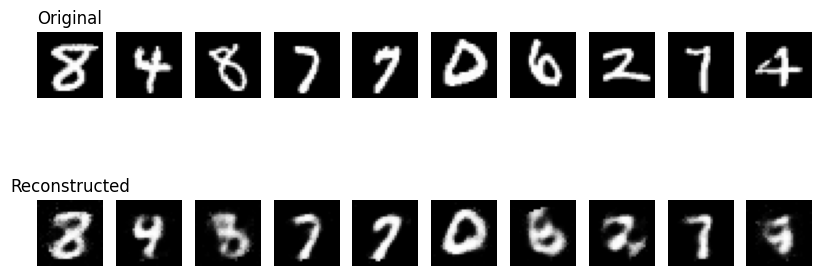

In [62]:
# 5. Evaluate
print("reconstructing...")
X_test_reconstructed = autoencoder.forward(X_test[:1000]) # Predict on a subset to save memory if needed

# 6. Visualize
n_samples = 10
plt.figure(figsize=(10, 4))
for i in range(n_samples):
    # Original
    plt.subplot(2, n_samples, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title('Original')

    # Reconstructed
    plt.subplot(2, n_samples, i + 1 + n_samples)
    plt.imshow(X_test_reconstructed[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title('Reconstructed')
plt.show()

In [63]:
from lib import Sequential, Dense, ReLU, Sigmoid, MSELoss, SGDOptimizer as SGD  
encoder = Sequential(autoencoder.layers[:6])

def extract_features(model, X, bs=512):
    out = []
    for i in range(0, X.shape[0], bs):
        out.append(model.forward(X[i:i+bs]))
    return np.vstack(out)

Z_train = extract_features(encoder, X_train)
Z_test  = extract_features(encoder, X_test)



Accuracy: 0.8685
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1343
           1       0.94      0.97      0.95      1600
           2       0.84      0.84      0.84      1380
           3       0.83      0.84      0.84      1433
           4       0.86      0.88      0.87      1295
           5       0.79      0.73      0.76      1273
           6       0.92      0.92      0.92      1396
           7       0.89      0.90      0.89      1503
           8       0.84      0.83      0.84      1357
           9       0.83      0.80      0.82      1420

    accuracy                           0.87     14000
   macro avg       0.87      0.87      0.87     14000
weighted avg       0.87      0.87      0.87     14000



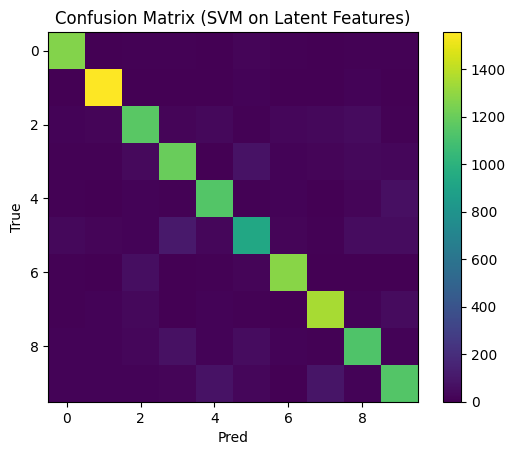

In [64]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

svm = make_pipeline(StandardScaler(), LinearSVC(C=1.0))
svm.fit(Z_train, y_train)

y_pred = svm.predict(Z_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix (SVM on Latent Features)")
plt.xlabel("Pred")
plt.ylabel("True")
plt.colorbar()
plt.show()


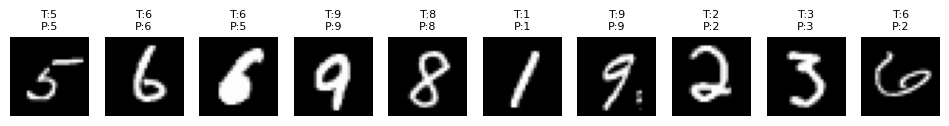

In [65]:
def show_random(n=12):
    idxs = np.random.choice(len(X_test), size=n, replace=False)
    plt.figure(figsize=(12,3))
    for j, idx in enumerate(idxs):
        x = X_test[idx]
        true = y_test[idx]
        pred = svm.predict(Z_test[idx:idx+1])[0]

        plt.subplot(1, n, j+1)
        plt.imshow((x.reshape(28,28)*255).astype(np.uint8), cmap="gray")
        plt.title(f"T:{true}\nP:{pred}", fontsize=8)
        plt.axis("off")
    plt.show()

show_random(10)


In [ ]:
import time
import numpy as np
import tensorflow as tf


def half_mse(y_true, y_pred):
    return 0.5 * tf.reduce_mean(tf.square(y_true - y_pred))




xor_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(4),
    tf.keras.layers.Activation("tanh"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Activation("tanh"),
])

lr = 1.0
epochs = n_epochs
_ = xor_model(np.zeros((1, 2), dtype=np.float32))
dense_layers = [l for l in xor_model.layers if isinstance(l, tf.keras.layers.Dense)]
assert len(dense_layers) == 2
W1 = W1_init.astype(np.float32)                  # (2,4)
b1 = b1_init.astype(np.float32).reshape(-1)      # (1,4)->(4,)
W2 = W2_init.astype(np.float32)                  # (4,1)
b2 = b2_init.astype(np.float32).reshape(-1)      # (1,1)->(1,)

# Sanity checks
assert W1.shape == (2, 4), f"W1 shape wrong: {W1.shape}"
assert b1.shape == (4,),   f"b1 shape wrong: {b1.shape}"
assert W2.shape == (4, 1), f"W2 shape wrong: {W2.shape}"
assert b2.shape == (1,),   f"b2 shape wrong: {b2.shape}"

# Set initial weights
dense_layers[0].set_weights([W1, b1])
dense_layers[1].set_weights([W2, b2])

lr = 1.0
epochs = n_epochs
xor_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=lr),
    loss=half_mse
)

t0 = time.perf_counter()
hist = xor_model.fit(X, y_true, epochs=epochs, verbose=0)
t_train = time.perf_counter() - t0


y_pred = xor_model.predict(X, verbose=0)

print("Train time (s):", t_train)
print("Final loss:", hist.history["loss"][-1])
print("Raw preds:\n", np.round(y_pred, 3))

y_pred_sign = np.where(y_pred >= 0, 1, -1).astype(np.int8)
print("Pred sign:\n", y_pred_sign.ravel())
print("True:\n", y_true.ravel().astype(np.int8))

Train time (s): 450.91225618000135
Final loss: 2.194677472289186e-05
Raw preds:
 [[-0.993]
 [ 0.994]
 [ 0.994]
 [-0.992]]
Pred sign:
 [-1  1  1 -1]
True:
 [-1  1  1 -1]


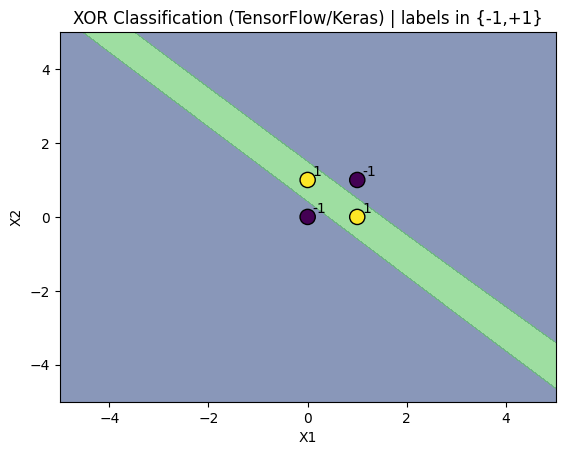

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# Grid
xx, yy = np.meshgrid(
    np.linspace(-5.0, 5.0, 200),
    np.linspace(-5.0, 5.0, 200)
)
grid_points = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)

# Predict on grid
Z = xor_model.predict(grid_points, verbose=0).reshape(xx.shape)  # values in [-1,1]

plt.figure()
# boundary at 0 because output is tanh (negative vs positive)
plt.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.6)

# Plot points (color by class -1/+1)
plt.scatter(X[:, 0], X[:, 1], s=120, c=y_true.ravel(), edgecolors="k")

for i, txt in enumerate(y_true.ravel()):
    plt.text(X[i, 0] + 0.1, X[i, 1] + 0.1, str(int(txt)))

plt.title("XOR Classification (TensorFlow/Keras) | labels in {-1,+1}")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()



Autoencoder
